# Étude de l'impact de la réduction des données

In [1]:
import time


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from tqdm.notebook import trange, tqdm

from tools import Modelisation, datasets, convert_keys_to_int


t = time.time()

In [2]:
best_LR = "LR_RFECV"
best_Forest = "Forest_RFECV"
best_XGBoost = "XGBoost_RFECV"

In [3]:
import json

# Régression logistique
with open('backups/RFECV_LR.json') as column_file:
    LR_COLUMNS = json.load(column_file)
    LR_COLUMNS_QUANT = LR_COLUMNS['columns_quant']
    LR_COLUMNS_CAT = LR_COLUMNS['columns_cat']
    LR_COLUMNS = LR_COLUMNS_QUANT + LR_COLUMNS_CAT

with open('backups/PARAMS_LR.json') as param_file:
    LR_PARAMS = json.load(param_file)[best_LR]
    LR_PARAMS = convert_keys_to_int(LR_PARAMS)

print(f'Variables explicatives régression logistique ({len(LR_COLUMNS)}) :')
display(LR_COLUMNS)

print(f'Meilleurs paramètres régression logistique ({len(LR_PARAMS)}) :')
display(LR_PARAMS)

# Forêt aléatoires
with open('backups/RFECV_Forest.json') as column_file:
    F_COLUMNS = json.load(column_file)
    F_COLUMNS_QUANT = F_COLUMNS['columns_quant']
    F_COLUMNS_CAT = F_COLUMNS['columns_cat']
    F_COLUMNS = F_COLUMNS_QUANT + F_COLUMNS_CAT

with open('backups/PARAMS_Forest.json') as param_file:
    F_PARAMS = json.load(param_file)[best_Forest]
    F_PARAMS = convert_keys_to_int(F_PARAMS)

print(f'Variables explicatives forêt aléatoires ({len(F_COLUMNS)}) :')
display(F_COLUMNS)

print(f'Meilleurs paramètres forêt aléatoires ({len(F_PARAMS)}) :')
F_PARAMS['class_weight'] = {int(k): v for k,v in F_PARAMS['class_weight'].items()}
display(F_PARAMS)

# XGBoost
with open('backups/RFECV_XGBoost.json') as column_file:
    XG_COLUMNS = json.load(column_file)
    XG_COLUMNS_QUANT = XG_COLUMNS['columns_quant']
    XG_COLUMNS_CAT = XG_COLUMNS['columns_cat']
    XG_COLUMNS = XG_COLUMNS_QUANT + XG_COLUMNS_CAT

with open('backups/PARAMS_XGBoost.json') as param_file:
    XG_PARAMS = json.load(param_file)[best_XGBoost]
    XG_PARAMS = convert_keys_to_int(XG_PARAMS)

print(f'Variables explicatives XGBoost ({len(XG_COLUMNS)}) :')
display(XG_COLUMNS)

print(f'Meilleurs paramètres XGBoost ({len(XG_PARAMS)}) :')
display(XG_PARAMS)

# Seuils ajustés
with open('backups/THRESHOLD.json') as threshold_file:
    SEUILS = json.load(threshold_file)

print("Seuils ajustés :")
display(SEUILS)

Variables explicatives régression logistique (11) :


['campaignctrlast24h',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'campaignscenario_13',
 'device_type_Desktop',
 'device_type_iPhone',
 'display_env_app_ios',
 'is_interstitial_True',
 'target_env_2']

Meilleurs paramètres régression logistique (2) :


{'C': 7.880462815669905, 'class_weight': {0: 1, 1: 20}}

Variables explicatives forêt aléatoires (9) :


['campaignctrlast24h',
 'contextid',
 'dayssincelastvisitdouble',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'zonecostineuro',
 'is_interstitial_True']

Meilleurs paramètres forêt aléatoires (8) :


{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 1, 1: 32},
 'bootstrap': False,
 'n_jobs': -1}

Variables explicatives XGBoost (9) :


['campaignctrlast24h',
 'contextid',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'device_type_Android',
 'device_type_Desktop',
 'device_type_iPad',
 'is_interstitial_True']

Meilleurs paramètres XGBoost (11) :


{'subsample': 1.0,
 'scale_pos_weight': 16.5,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 0.6,
 'booster': 'gbtree',
 'objective': 'binary:logistic',
 'n_jobs': -1}

Seuils ajustés :


{'LR': 0.4898437499999999,
 'Forest': 0.6426757812500004,
 'XGBoost': 0.4701171874999999}

In [4]:
data_frac_list = np.logspace(-3, 0, 10)
print(f"Minimum : {data_frac_list[0]*100:.3f}%")
print(f"2ème : {data_frac_list[1]*100:.3f}%")
data_frac_list

Minimum : 0.100%
2ème : 0.215%


array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])

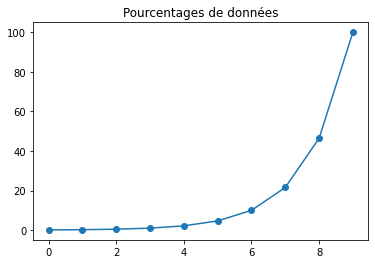

In [5]:
plt.plot(100*data_frac_list, marker='o')
plt.title("Pourcentages de données")
plt.show()

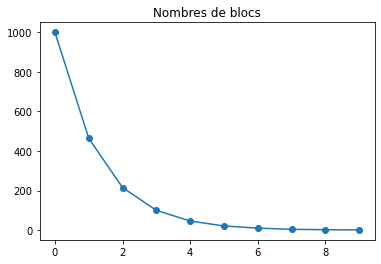

In [6]:
plt.plot([int(1/elem) for elem in data_frac_list], marker='o')
plt.title("Nombres de blocs")
plt.show()

## Régression logistique

In [7]:
df_train_all = pd.read_csv('data/df_train_prepro.csv').sample(frac=1, random_state=1234)
df_test = pd.read_csv('data/df_test_prepro.csv').sample(frac=1, random_state=1234)
datasets_df_test = datasets(df_test, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
X_test = datasets_df_test['X_only_quant_scaled']
y_test = datasets_df_test['y']

**Première idée non robuste avec un seul calcul pour chaque pourcentage**

In [8]:
%%time
SCORES_LR = []
for data_frac in tqdm(data_frac_list):
    df_train = df_train_all.sample(frac=data_frac, random_state=1234)
    datasets_df_train = datasets(df_train, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
    X_train = datasets_df_train['X_only_quant_scaled']
    y_train = datasets_df_train['y']
    
    m = Modelisation(X_train, y_train, LogisticRegression(**LR_PARAMS), X_test=X_test, y_test=y_test)
#     m = Modelisation(X_train, y_train, LogisticRegression(**LR_PARAMS), X_test=X_test, y_test=y_test, seuil=SEUILS['LR'])

    metrics = m.metrics_score
    metrics['model_name'] = 'Régression logistique'
    metrics['data_frac'] = data_frac
    metrics['training_time'] = m.training_time
    metrics['prediction_time'] = m.prediction_time
    SCORES_LR.append(metrics)
SCORES_LR = pd.DataFrame(SCORES_LR)

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 22.4 s


In [9]:
def graph(scores, column='f3'):
    fig, ax = plt.subplots()
    for model_name in scores['model_name'].unique():
        scores_model = scores[scores.model_name == model_name]    
        ax.plot(100*scores_model['data_frac'], scores_model[column], label=model_name, marker='o')
    ax.set_xscale('log')
    ax.set_xlabel("Pourcentage de données")
    ax.set_ylabel(column)
    ax.legend()
#     pdf.export()
    plt.show()

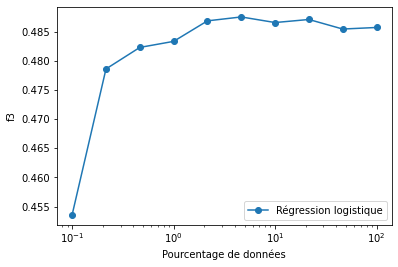

In [10]:
graph(SCORES_LR)

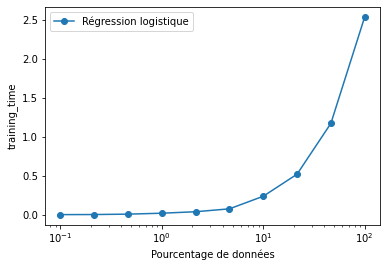

In [11]:
graph(SCORES_LR, column='training_time')

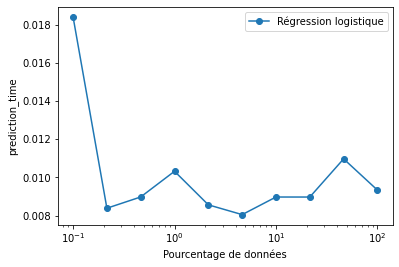

In [12]:
graph(SCORES_LR, column='prediction_time')

**Méthode plus robuste avec moyenne**

In [13]:
%%time
SCORES_LR = []
for data_frac in tqdm(data_frac_list, desc="data_frac loop"):
    nb_blocs = int(1/data_frac)
    df_train_list = np.array_split(df_train_all, nb_blocs)
    scores_frac = []
    for df_train in tqdm(df_train_list, desc="split loop", leave=False):
        datasets_df_train = datasets(df_train, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
        X_train = datasets_df_train['X_only_quant_scaled']
        y_train = datasets_df_train['y']    

        m = Modelisation(X_train, y_train, LogisticRegression(**LR_PARAMS), X_test=X_test, y_test=y_test)
    #     m = Modelisation(X_train, y_train, LogisticRegression(**LR_PARAMS), X_test=X_test, y_test=y_test, seuil=SEUILS['LR'])

        metrics = m.metrics_score
        metrics['data_frac'] = data_frac
        metrics['training_time'] = m.training_time
        metrics['prediction_time'] = m.prediction_time
        scores_frac.append(metrics)
    scores_frac = pd.DataFrame(scores_frac)
    mean = scores_frac.mean()
    mean['model_name'] = 'Régression logistique'
    SCORES_LR.append(mean)
SCORES_LR = pd.DataFrame(SCORES_LR)

data_frac loop:   0%|          | 0/10 [00:00<?, ?it/s]

split loop:   0%|          | 0/1000 [00:00<?, ?it/s]

split loop:   0%|          | 0/464 [00:00<?, ?it/s]

split loop:   0%|          | 0/215 [00:00<?, ?it/s]

split loop:   0%|          | 0/100 [00:00<?, ?it/s]

split loop:   0%|          | 0/46 [00:00<?, ?it/s]

split loop:   0%|          | 0/21 [00:00<?, ?it/s]

split loop:   0%|          | 0/10 [00:00<?, ?it/s]

split loop:   0%|          | 0/4 [00:00<?, ?it/s]

split loop:   0%|          | 0/2 [00:00<?, ?it/s]

split loop:   0%|          | 0/1 [00:00<?, ?it/s]

Wall time: 12min 15s


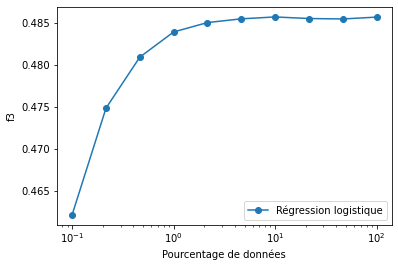

In [14]:
graph(SCORES_LR)

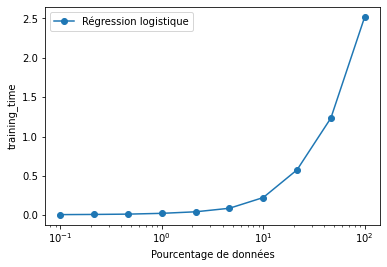

In [15]:
graph(SCORES_LR, column='training_time')

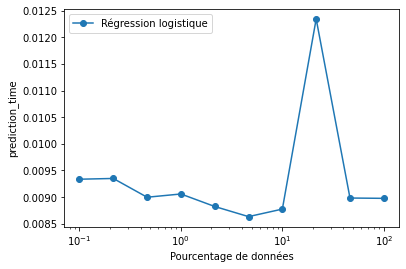

In [16]:
graph(SCORES_LR, column='prediction_time')

In [17]:
print(f"Durée totale d'exécution : {time.strftime('%H:%M:%S', time.gmtime(time.time() - t))}")

Durée totale d'exécution : 00:13:02
